# Анализ текста на токсичность

## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении имеется набор данных с разметкой о токсичности правок.
Модель должна давать значение метрики качества F1 не меньше 0.75.

**Тип задачи:** классификация

## Описание данных

* `text`  - текст комментария.
* `toxic` — целевой признак.

## План работы

* Загрузка и подготовка данных
* Обучение моделей
* Общие выводы

## Установки, импорты и настройки

Импорты:

In [1]:
import re
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

Настройки:

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)

## Загрузка и подготовка данных

### Загрузка и осмотр данных

In [3]:
try:
    original_df = pd.read_csv('/datasets/toxic_comments.csv')
    display('Данные из практикума загружены.')
except:
    original_df = pd.read_csv('datasets/toxic_comments.csv')
    display('Локальные данные загружены.')

original_df.name = 'original_df'

'Локальные данные загружены.'

Первый взгляд на данные:

In [4]:
display('Размер:', original_df.shape)
display('Голова:', original_df.head())
display('Хвост:', original_df.tail())
display('Информация', original_df.info())

'Размер:'

(159292, 3)

'Голова:'

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


'Хвост:'

,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


'Информация'

None

Взглянем на наличие прямых дублей:

In [5]:
original_df.duplicated().sum()

0

Создадим рабочую копию датафрейма:

In [6]:
df = original_df.copy()

Избавимся от столбца с индексом, он избыточен:

In [7]:
df.drop(columns=['Unnamed: 0'], inplace=True)

Взглянем сразу на распределение классов:

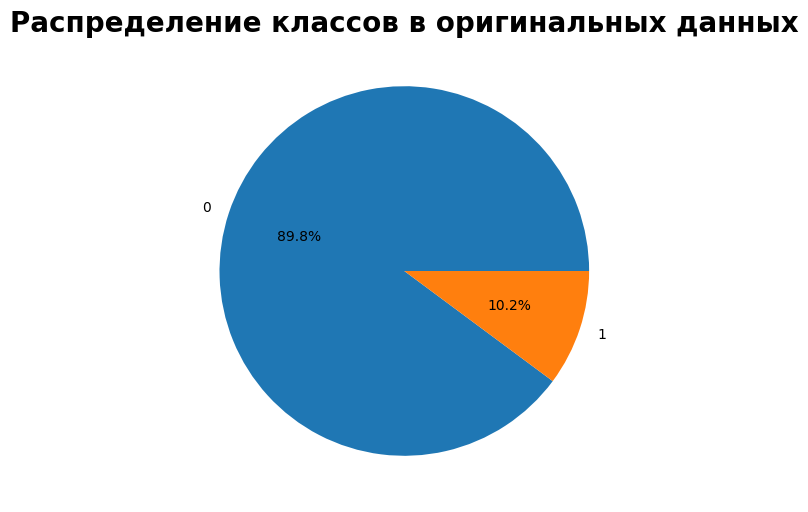

In [8]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title('Распределение классов в оригинальных данных', fontsize=20, weight='bold')
ax.pie(original_df['toxic'].value_counts(normalize=True), autopct='%1.1f%%', labels=[0, 1]);

**Выводы:**
* Более 150 семплов текста.
* Пропусков нет, дублей нет.
* Данные skewed. Токсичных комментариев всего около 10%.

### Подготовка данных

Приведем текст к нижнему регистру:

In [9]:
df['text_edit'] = df['text'].str.lower()

Удалим переносы строк и спецсимволы.

In [10]:
df['text_edit'] = df['text_edit'].apply(lambda x: x.replace('\n', ' '))
df['text_edit'] = df['text_edit'].apply(lambda x: x.replace('\xa0', ' '))

Оставим только слова:

In [11]:
df['text_edit'] = df['text_edit'].apply(lambda x: ' '.join(re.sub(r'[^a-zA-Z]', ' ', x).split()))

Избавимся от stopwords:

In [12]:
%%time
nltk.download('stopwords')
stops = set(stopwords.words('english'))

def delete_stops(df):
    texts = []
    for text in df['text_edit'].values:
        result = []
        words = text.split()
        for word in words:
            if word not in stops:
                result.append(word)
        result = ' '.join(result)
        texts.append(result)

    return pd.Series(texts, index=df.index)


df['text_edit'] = delete_stops(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\denis\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


CPU times: total: 3.11 s
Wall time: 3.45 s


Сделаем лемматизацию текстов:

In [13]:
%%time
nltk.download('wordnet')
wnl = WordNetLemmatizer()

def lemmatize_text(text):
    lemmas = []
    for word in text.split():
        lemmas.append(wnl.lemmatize(word))

    return " ".join(lemmas)

df['text_edit'] = df['text_edit'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\denis\AppData\Roaming\nltk_data...


CPU times: total: 30 s
Wall time: 32.9 s


По итогу имеем ряд строк, которые изначально не имели особой смысловой нагрузки и после всех манипуляций превратились в пустые строки:

In [14]:
idx = df[df['text_edit'] == ''].index
display('Оригинальные строки:', original_df['text'].loc[idx])
display('Строки после внесения изменений:', df[df['text_edit'] == '']['text_edit'])

'Оригинальные строки:'

2091                           No, it doesn´t.80.228.65.162
2400                                   Here, here and here.
3983                      From here\n\nFrom here 160.80.2.8
4475      1993\n\n1994\n\n1995\n\n1996\n\n1997\n\n1998\n...
6289                                   193.61.111.53  15:00
                                ...                        
148595                                 she did 76.122.79.82
151107                        10 - 2010 04 08 to 2010 05 12
152543                         SAME FOR THIS 166.137.240.20
153041    which is OVER 9000 OVER 9000 OVER 9000 OVER 90...
158740                   Why don't you do it? 24.68.148.215
Name: text, Length: 61, dtype: object

'Строки после внесения изменений:'

2091       
2400       
3983       
4475       
6289       
         ..
148595     
151107     
152543     
153041     
158740     
Name: text_edit, Length: 61, dtype: object

Удалим эти строки:

In [15]:
idx = df[df['text_edit'] == ''].index
display(df.shape)
df.drop(idx, axis='index', inplace=True)
display(df.shape)

(159292, 3)

(159231, 3)

Разделим данные на тестовую и тренировочную выборки:

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df['text_edit'],
                                                    df['toxic'],
                                                    test_size=0.2,
                                                    random_state=777)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((127384,), (31847,), (127384,), (31847,))

### IF-IDF

Используем TF-IDF для векторизации текстов:

In [17]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

TfidfVectorizer()

## Обучение моделей

Попробуем применить пару моделей: LogisticRegression и KNN

Для начала выделим dev выборку для подбора параметров:

In [18]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=777)
X_train.shape, X_dev.shape, X_test.shape, y_train.shape, y_dev.shape, y_test.shape

((95538,), (31846,), (31847,), (95538,), (31846,), (31847,))

In [19]:
X_train_tf_idf = vectorizer.transform(X_train)
X_dev_tf_idf = vectorizer.transform(X_dev)
X_test_tf_idf = vectorizer.transform(X_test)
X_train_tf_idf, X_dev_tf_idf, X_test_tf_idf

(<95538x139039 sparse matrix of type '<class 'numpy.float64'>'
 	with 2555853 stored elements in Compressed Sparse Row format>,
 <31846x139039 sparse matrix of type '<class 'numpy.float64'>'
 	with 851393 stored elements in Compressed Sparse Row format>,
 <31847x139039 sparse matrix of type '<class 'numpy.float64'>'
 	with 829242 stored elements in Compressed Sparse Row format>)

### LogisticRegression

Попробуем логистическую регрессию и подберем для неё оптимальный threshold:

In [20]:
%%time
best_threshold = -1
best_c = -1
best_f1 = -1
# Для экономии времени оставлены только лучшие диапазоны +-. Подбор проводился на более широких.
to_check_threshold = [i/100 for i in range(25,35)]
to_check_c = [1, 2, 3, 4, 5, 6]

for c in to_check_c:
    model = LogisticRegression(solver="saga", n_jobs=-1, C=c, max_iter = 200, random_state=777)
    model.fit(X_train_tf_idf, y_train)
    for threshold in to_check_threshold:
        probs = model.predict_proba(X_dev_tf_idf)
        probs_pos = [x[1] for x in probs]
        pred = [0 if x < threshold else 1 for x in probs_pos]
        f1 = f1_score(y_dev, pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_c = c

display(f'Максимальный f1: {best_f1:.2%}')
display(f'Оптимальный threshold: {best_threshold:.2f}')
display(f'Оптимальный С: {best_c:.0f}')

'Максимальный f1: 79.44%'

'Оптимальный threshold: 0.30'

'Оптимальный С: 3'

CPU times: total: 25.6 s
Wall time: 25.7 s


### KNN

Проделаем аналогичные шаги для KNeighborsClassifier и попробуем подобрать оптимальное количество соседей:

In [21]:
%%time
best_n_neighbors = 0
best_f1 = 0

# Для экономии времени оставлены только лучшие диапазоны +-. Подбор проводился на более широких.
for i in range(14, 16):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train_tf_idf, y_train)
    prediction = model.predict(X_dev_tf_idf)
    f1 = f1_score(y_dev, prediction)
    if f1 > best_f1:
        best_f1 = f1
        best_n_neighbors = i

display(f'Максимальный f1: {best_f1:.2%}')
display(f'Оптимальный n_neighbors: {best_n_neighbors:.0f}')

'Максимальный f1: 67.72%'

'Оптимальный n_neighbors: 15'

CPU times: total: 4min 13s
Wall time: 4min 18s


### Тестирование лучшей модели на тестовых данных

Из предложенных 2 моделей лучший результат показала логистическая регрессия с C=3 и threshold=0.30. Заново обучим эту модель на всей тренировочной подвыборке (включая dev):

In [22]:
# Объединим снова train и dev
X_train_dev = pd.concat([X_train, X_dev], axis='index')
y_train_dev = pd.concat([y_train, y_dev], axis='index')

# Векторизуем
X_train_dev_tf_idf = vectorizer.transform(X_train_dev)

In [23]:
# Обучаем модель
model = LogisticRegression(solver="saga", n_jobs=-1, C=best_c, max_iter = 200, random_state=777)
model.fit(X_train_dev_tf_idf, y_train_dev)

LogisticRegression(C=3, max_iter=200, n_jobs=-1, random_state=777,
                   solver='saga')

Протестируем на тестовой выборке:

In [24]:
%%time
probs = model.predict_proba(X_test_tf_idf)
probs_pos = [x[1] for x in probs]
pred = [0 if x < best_threshold else 1 for x in probs_pos]
f1 = f1_score(y_test, pred)
display(f'Результат на тестовой выборке: {f1:.2%}')

'Результат на тестовой выборке: 78.95%'

CPU times: total: 109 ms
Wall time: 177 ms


## Общие выводы

* Изучены размеченные текстовые данные магазина "Викишоп".
* Данные относительно чистые, более 150 тыс. текстовых семплов на английском языке без пропусков и дублей.
* Данные skewed, на токсичные тексты приходится около 10% выборки.
* Проведена предварительная подготовка текста для обучения:
    * Тексты приведены к нижнему регистру
    * Удалены спецсимволы
    * Удалено всё, что не представляет из себя слова
    * Удалены stopwords
    * Проведена лемматизация
    * Удалено незначительное количество семплов, которые после всех обработок выше остались пустыми
* Данные разделены на тренировочную и тестовую выборки, на основе тренировочной выборки настроен TfidfVectorizer()
* Протестированы 2 вида моделей: LogisticRegression и KNeighborsClassifier. На dev подвыборке подобраны оптимальные параметры threshold и n_neighbors. Лучшие результаты у логистической регрессии с показателями threshold=0.3, С=3.
* **Результаты по итогу тестирования лучшей модели на тестовой выборке по показателю f1 составил 78,95%, что выше обозначенного заказчиком минимального уровня.**